In [64]:
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense,BatchNormalization
from tensorflow.keras import applications
import tensorflow
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score

In [68]:
#SET DIRECTORY WITH DATA FOLDER INSIDE COMPRISING TRAIN, TEST AND VALIDATION DIRECTORIES ARRANGED IN COMPATIBILITY WITH KERAS IMAGEDATAGENERATORS
directory = r'C:\Users\Alankrit\Videos\PetImages'
# dimensions of our images.
img_width, img_height = 150, 150

print("Loading weights of TOP MODEL custom trained with the help of VGG16\n")

top_model_weights_path = os.path.join(directory,'bottleneck_fc_model.h5')



nb_test_samples = 2899


def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    
    test_datagen = ImageDataGenerator(rescale=1./255) #Just normalization (no zoom etc.) for test
    test_generator = test_datagen.flow_from_directory(
        os.path.join(directory,'data\\test'),
        target_size=(150, 150),
        batch_size=batch_size,shuffle=False,
        class_mode='binary')
    
    
    bottleneck_features_test = model.predict_generator(
        test_generator)
    
    np.save(open('bottleneck_features_test.npy', 'wb'),
            bottleneck_features_test)

Loading weights of TOP MODEL custom trained with the help of VGG16



In [69]:
print("Calling Function to Make Predictions from the VGG16 CONVOLUTIONAL BLOCKS")
save_bottlebeck_features()

Calling Function to Make Predictions from the VGG16 CONVOLUTIONAL BLOCKS
Found 2899 images belonging to 2 classes.


# EVALUATION MODEL -TEST SET PERF

In [70]:
print("Loading the Conv Blocks Prediction\n")
test_data = np.load(open('bottleneck_features_test.npy','rb'))
print("Shape of the Prediction by VGG16 CONV BLOCKS:",test_data.shape)



print("\nREPLICATING THE CUSTOM TOP MODEL STRUCTURE PRE-TRAINED WITH VGG16 CONV BLOCKS\n")
top_model = Sequential()
top_model.add(Flatten(input_shape=test_data.shape[1:]))
top_model.add(Dense(128, activation='relu'))
top_model.add(BatchNormalization())
top_model.add(Dense(1, activation='sigmoid'))

print("LOADING THE PRE-TRAINED TOP MODEL WEIGHTS\n")
top_model.load_weights(top_model_weights_path)
print("LOCKED&LOADED, READY FOR PREDICTIONS")

Loading the Conv Blocks Prediction

Shape of the Prediction by VGG16 CONV BLOCKS: (2899, 4, 4, 512)

REPLICATING THE CUSTOM TOP MODEL STRUCTURE PRE-TRAINED WITH VGG16 CONV BLOCKS

LOADING THE PRE-TRAINED TOP MODEL WEIGHTS

LOCKED&LOADED, READY FOR PREDICTIONS


In [71]:
#Prediction of Probabilities (0-1)

print("MAKING TOP LAYER PREDICTIONS...\n")
pred= top_model.predict(test_data)
print("Done :)")

#SETTING A THRESHOLD OF 0.5 FOR CLASSES
for i in range(len(pred)):
    
    if pred[i]<0.5:
        pred[i]=0
        
    if pred[i]>0.5:
        pred[i]=1

MAKING TOP LAYER PREDICTIONS...

Done :)


# PERFORMANCE METRICS EVALUATION

Evaluating Model Predictions on TEST DATASET


F1_Score: 0.9201255667945588 
Accuracy: 0.921007243877199 


Confusion matrix, without normalization


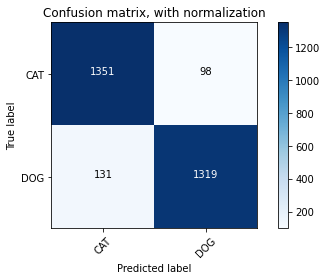

In [72]:
print("Evaluating Model Predictions on TEST DATASET")
test = test_generator.classes
f1 = f1_score(test,pred)
acc = accuracy_score(test,pred)
print("\n\nF1_Score:",f1,"\nAccuracy:",acc,"\n\n")



#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()

#plot_confusion_matrix(cnf_matrix, classes=['CAT','DOG'],
                      #title='Confusion matrix, without normalization')

plot_confusion_matrix(cnf_matrix, classes=['CAT','DOG'],normalize=False,
                      title='Confusion matrix, with normalization')